In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import timeit
from projectors import *
from scipy.stats import norm, multivariate_normal

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

In [2]:
DIM_X = 10
NUM_B = 12
eps = 0.1 / NUM_B
W = np.random.randn(NUM_B, DIM_X)
W = np.apply_along_axis(lambda x: x / np.linalg.norm(x), 1, W)
tau = np.fabs(np.random.randn(NUM_B))

In [3]:
def calculate_probas(W,tau):
    return norm.cdf(-tau)

In [4]:
probas = calculate_probas(W, tau)

In [5]:
def Bound(W, tau, mix_index, x):
    return W[mix_index].dot(x) >= tau[mix_index]

In [6]:
bound_wrap = lambda i, x: Bound(W, tau, i, x)

In [7]:
def generate_sample(W, tau, mix_index):
    if mix_index == len(W):
        return np.random.randn(DIM_X)
    w = W[mix_index]
    t = tau[mix_index]
    z = np.random.randn(DIM_X)
    u = np.random.rand()
    y = u * norm.cdf(-t)
    y = norm.ppf(y)
    return -y*w - z + (w.dot(z)) * w

In [8]:
generate_wrap = lambda i: generate_sample(W, tau, i)

In [9]:
class Mixture():
    def __init__(self, dist_func, boundaries, probas, gen_funcs):
        self.base_dist = dist_func
        self.boundaries = boundaries
        self.probas = probas
        self.gen_funcs = gen_funcs
#        for i, p in enumerate(self.probas):
#            self.mix_dist.append(lambda x: self.base_dist(x)*self.boundaries(i, x)/p)
            
    def set_alpha(self, alpha):
        self.alpha = alpha
        
    def mix_pdf(self, mix_index, x):
        return self.base_dist(x)*self.boundaries(mix_index, x)/ self.probas[mix_index]
    
    def mix_dist(self, x):
        res = 0
        for i, a in enumerate(self.alpha):
            if i != len(self.alpha) - 1:
                res += a*self.base_dist(x)*self.boundaries(i, x)/self.probas[i]
            else:
                res += a*self.base_dist(x)
        return res
    def sample(self):
        n = len(self.alpha)
        choice = np.random.choice(n, p=self.alpha)
        return self.gen_funcs(choice)
        
        

### First optimization task

$$
\text{Var } \hat \mu_{\alpha} = \frac 1n \left(\int \frac{H_{1:J}(x) p(x)}{\sum_{j=0}^J \alpha_j H_j (x) P_j^{-1}} \, dx  - \mu^2\right)\longrightarrow \min_{\alpha}
$$

We are going to use stochastic gradient descent. The stochastic gradient of this task, having $X_i \sim q_{\alpha}(x)$ is $-\dfrac{H_{1:J}(X_i) p^2(X_i) \vec q (X_i)}{q_{\alpha}^3(X_i)}$

In [ ]:
def func(alpha):
    

In [25]:
def log_barrier(bound_values, rho = 1):
    bound_values = np.log(bound_values)
    return - rho * np.sum(bound_values)

In [11]:
def backtracking_line_search(direction, func, grad_func, dom_func, point, alpha = 0.3, beta = 0.8):
    t = 1
    x = point
    while not dom_func(x + t*direction):
        t = beta*t
    while func(x + t*direction) > func(x) + alpha*t*(grad_func(x).dot(direction)):
        t = t*beta
    return t

In [19]:
def damped_newton(func, grad_func, hess, dom_func, point, tolerance = 1e-4):
    x = point
    while True:
        grad = grad_func(x).reshape((-1,1))
        direction = - np.linalg.pinv(hess(x)).dot(grad)
        decrement = grad.T.dot(np.linalg.pinv(hess(x)))
        decrement = decrement.dot(grad)
        if decrement**2 / 2 <= tolerance:
            break
        t = backtracking_line_search(direction.ravel(), func, grad_func, dom_func, x)
        x = x + t* direction.ravel()
    return x

In [24]:
while True:
    i = np.random.randint(12)
    if i <= 10:
        print("I am bored")
    else:
        print("I can't bear it anymore")
        break

I am bored
I am bored
I am bored
I am bored
I am bored
I am bored
I am bored
I am bored
I can't bear it anymore


#### Stochastic gradient descent

In [33]:

#######################################################333
#SHOULD BE FINISHED LATER
#########################################################
def sgd(objective, mixture, grad, zero_point, projector, C = 1, max_iter = 10**5):
    cur_alpha = zero_point
    estim = []
    alphas = [cur_alpha]
    cumsum = 0
    for i in range(max_iter):
        #f_theta = sample_dist(*cur_theta)
        #start_time = timeit.default_timer()
        try:
            mixture.set_alpha(cur_alpha)
            cur_x = mixture.sample()
        except:
            cur_alpha[np.argmax(cur_alpha)] += 1 - cur_alpha.sum()
            mixture.set_alpha(cur_alpha)
            cur_x = mixture.sample()
        #print(timeit.default_timer() - start_time)
        # estimation part
        
        #start_time = timeit.default_timer()
        x = cur_x
        tmp = objective(x)
        
        cumsum += tmp
        estim.append(cumsum / (i + 1))
        
        #print(timeit.default_timer() - start_time)
        # gradient part
        #start_time = timeit.default_timer()
        gradient = grad(x)
        
        #print(timeit.default_timer() - start_time)
        # step part
        step_size = C/np.sqrt(i+1)
        #step_size = C
        
        #start_time = timeit.default_timer()
        cur_alpha = cur_alpha - step_size*gradient ######################## check!!!bb
        #print(cur_alpha)
        cur_alpha = projector(cur_alpha) ################# necessary to check later
        alphas.append(cur_alpha)
        
        #print(timeit.default_timer() - start_time)
        if (i + 1) % 100 == 0:
            print("Iteration #{}".format(i + 1))
    return np.array(estim), alphas

In [34]:
dist_func = lambda x: multivariate_normal.pdf(x, np.zeros((DIM_X)), np.identity(DIM_X))
mixture = Mixture(dist_func, bound_wrap, probas, generate_wrap)

def obj1(mixture, x):
    num_b = len(probas)
    h = 0
    for i in range(num_b):
        if mixture.boundaries(i, x) > 0:
            h = 1
            break
    return h*mixture.base_dist(x) / mixture.mix_dist(x)

def grad1(mixture, x):
    num_b = len(probas)
    h = 0
    for i in range(num_b):
        if mixture.boundaries(i, x) > 0:
            h = 1
            break
    coef = h*(mixture.base_dist(x)**2) / (mixture.mix_dist(x)**3)
    g = [coef*mixture.mix_pdf(i, x) for i in range(num_b)]
    g.append(coef*mixture.base_dist(x))
    return np.array(g)
    

In [35]:
obj = lambda x: obj1(mixture, x)
grad = lambda x: grad1(mixture, x)


In [36]:
zero_p = (1 / (NUM_B + 1)) * np.ones((NUM_B + 1))
proj = SimplexProjector(epsilon = eps)

In [37]:
est1, alphas = sgd(obj, mixture, grad, zero_p, proj, max_iter= 10**4)

Iteration #100
Iteration #200
Iteration #300
Iteration #400
Iteration #500
Iteration #600
Iteration #700
Iteration #800
Iteration #900
Iteration #1000
Iteration #1100
Iteration #1200
Iteration #1300
Iteration #1400
Iteration #1500
Iteration #1600
Iteration #1700
Iteration #1800
Iteration #1900
Iteration #2000
Iteration #2100
Iteration #2200
Iteration #2300
Iteration #2400
Iteration #2500
Iteration #2600
Iteration #2700
Iteration #2800
Iteration #2900
Iteration #3000
Iteration #3100
Iteration #3200
Iteration #3300
Iteration #3400
Iteration #3500
Iteration #3600
Iteration #3700
Iteration #3800
Iteration #3900
Iteration #4000
Iteration #4100
Iteration #4200
Iteration #4300
Iteration #4400
Iteration #4500
Iteration #4600
Iteration #4700
Iteration #4800
Iteration #4900
Iteration #5000
Iteration #5100
Iteration #5200
Iteration #5300
Iteration #5400
Iteration #5500
Iteration #5600
Iteration #5700
Iteration #5800
Iteration #5900
Iteration #6000
Iteration #6100
Iteration #6200
Iteration #6300
I

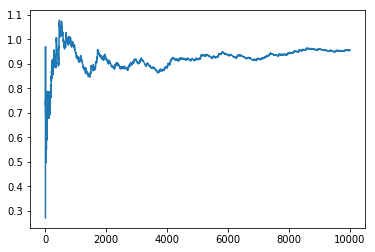

In [40]:
plt.plot(est1)

In [42]:
alphas

[array([ 0.07692308,  0.07692308,  0.07692308,  0.07692308,  0.07692308,
         0.07692308,  0.07692308,  0.07692308,  0.07692308,  0.07692308,
         0.07692308,  0.07692308,  0.07692308]),
 array([ 0.00833333,  0.10134494,  0.10134494,  0.0166131 ,  0.04651713,
         0.10134494,  0.10134494,  0.10134494,  0.10134494,  0.03652006,
         0.10134494,  0.10134494,  0.08125686]),
 array([ 0.05585147,  0.14886307,  0.14886307,  0.06413124,  0.09403526,
         0.00833333,  0.00833333,  0.14886307,  0.14886307,  0.00833333,
         0.14886307,  0.00833333,  0.00833333]),
 array([ 0.07146588,  0.16447749,  0.00833333,  0.07974565,  0.10964968,
         0.00833333,  0.02394775,  0.16447749,  0.16447749,  0.02394775,
         0.16447749,  0.00833333,  0.00833333]),
 array([ 0.0870803 ,  0.1800919 ,  0.02394775,  0.09536007,  0.1252641 ,
         0.02394775,  0.03956216,  0.1800919 ,  0.1800919 ,  0.03956216,
         0.00833333,  0.00833333,  0.00833333]),
 array([ 0.10622327,  0.0